In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataframe_noise = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv", parse_dates=True, index_col="timestamp")
dataframe_jumping_noise = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv", parse_dates=True, index_col="timestamp")

In [3]:
dataframe_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
dataframe_jumping_noise.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


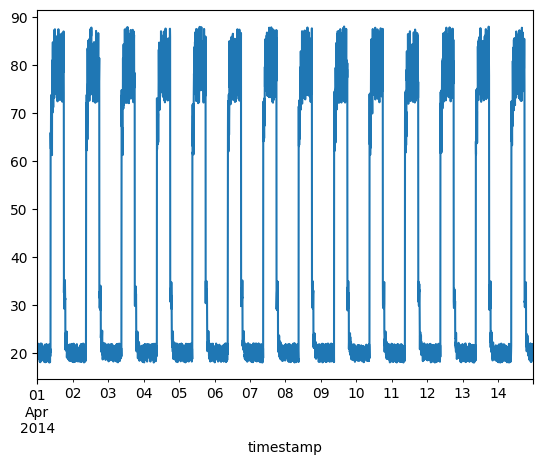

In [5]:
fig, ax = plt.subplots()
dataframe_noise.plot(legend=False, ax=ax)
plt.show()

# Noise 가 있는 data
### 데이터 포인트 사이의 노이스

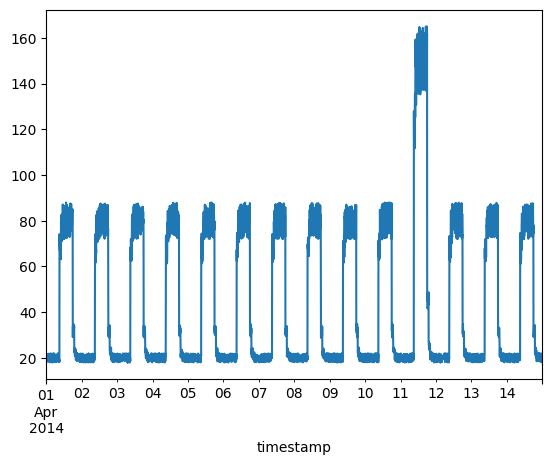

In [6]:
fig, ax = plt.subplots()
dataframe_jumping_noise.plot(legend=False, ax=ax)
plt.show()

In [58]:
dataframe_noise.shape

(4032, 1)

In [7]:
TIME_STEPS = 100

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(dataframe_noise.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3933, 100, 1)


In [8]:
x_train.shape

(3933, 100, 1)

In [9]:
x_train.shape

(3933, 100, 1)

### model

In [10]:
model = keras.Sequential(
    [
        ## 3933,100,1의 shape에서 각 들어오는 입력은 (100,1)
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        ## 1d가 있는 이유 #이미지 데이터가없기 때문에 -> 시계열과 text문제에서 주로 사용
        ## 각 feature 를 찾을수 있는가?
        ## kerenl size는 모든 cnn에서 동
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        ## transpose layer?
        ### 일반적으로 변환을 하려고 할때 사용
        ## 하나의 출력 시퀀스만 예측을 해야한다.
        ### 따라서 transpose를 이용해서 출력의 크기나 모양 변경
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 16)           1808      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          3616      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           225       
 ranspose)                                                       
                                                        

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.
## 즉 재구성모델이기 때문에 input과 target이 같음

##

In [11]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 17s 35ms/step - loss: 1001.3188 - val_loss: 159.4912
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 131.8891 - val_loss: 97.0683
Epoch 3/50
25/25 [==============================] - 0s 10ms/step - loss: 71.9657 - val_loss: 51.8574
Epoch 4/50
25/25 [==============================] - 0s 11ms/step - loss: 39.3330 - val_loss: 30.5936
Epoch 5/50
25/25 [==============================] - 0s 11ms/step - loss: 25.2782 - val_loss: 20.7544
Epoch 6/50
25/25 [==============================] - 0s 11ms/step - loss: 18.5956 - val_loss: 15.9801
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 14.9421 - val_loss: 13.1443
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 12.6724 - val_loss: 11.2569
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 11.0684 - val_loss: 9.8820
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 9.9328 - val_loss

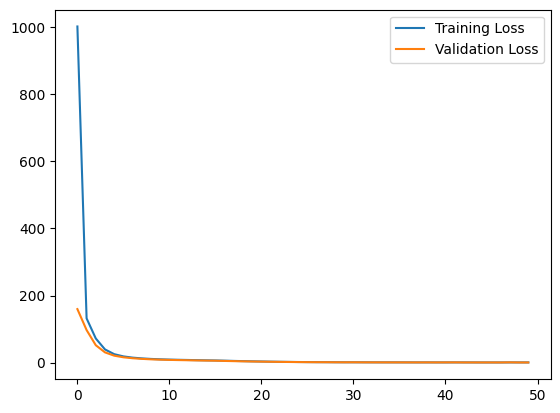

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [49]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

threshold = np.max(train_mae_loss)
threshold

123/123 [==============================] - 0s 3ms/step


1.0101729667219137

In [50]:
len(x_train)

3933

In [51]:
x_train_pred.shape

(3933, 100, 1)

## Noise 데이터에 대한 데이터를 test로
## 앞서 만든 모델과의 차이가 기존 model의 최대 cost 보다 크다면 anomalies @이상치라고 정의

In [52]:
x_test = create_sequences(dataframe_jumping_noise.values)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

anomalies = test_mae_loss > threshold

123/123 [==============================] - 0s 2ms/step


In [69]:
np.unique(anomalies,
          return_counts = True)

(array([False,  True]), array([3773,  160]))

In [82]:
np.where(anomalies==True)

(array([ 107, 1835, 2889, 2890, 2891, 2892, 2893, 2894, 2896, 2897, 2905,
        2909, 2910, 2913, 2917, 2921, 2923, 2924, 2925, 2928, 2929, 2930,
        2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941,
        2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952,
        2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963,
        2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974,
        2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985,
        2986, 2987, 2997, 2998, 2999, 3000, 3001, 3003, 3004, 3005, 3006,
        3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017,
        3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028,
        3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039,
        3040, 3041, 3042, 3044, 3045, 3046, 3048, 3049, 3050, 3052, 3053,
        3054, 3056, 3057, 3058, 3060, 3061, 3062, 3064, 3065, 3066, 3068,
        3069, 3070, 3072, 3073, 3074, 

In [89]:
anomalous_data_indices = []
TestTimeStamp=50
for data_idx in range(TestTimeStamp - 1, len(dataframe_jumping_noise) - TestTimeStamp + 1):
    # check = np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx])
    # print(check)
    if np.all(anomalies[data_idx - TestTimeStamp + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
anomalous_data_indices

[2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 3982]

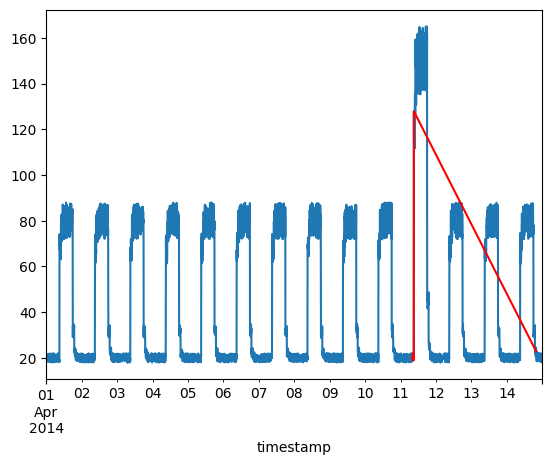

,value
timestamp,
2014-04-11 08:05:00,20.044856
2014-04-11 08:10:00,18.958609
2014-04-11 08:15:00,21.729408
2014-04-11 08:20:00,21.926084
2014-04-11 08:25:00,21.258791
2014-04-11 08:30:00,19.259135
2014-04-11 08:35:00,19.613950
2014-04-11 08:40:00,18.969223
2014-04-11 08:45:00,21.563032


In [90]:
df_subset = dataframe_jumping_noise.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
dataframe_jumping_noise.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()
df_subset

### pyod?
## 아웃라이어와 이상치를 찾는데 사용

In [25]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185331 sha256=2f6a2a3c8ec7197bafaf578fb6145a8400f4ed23431d7db287dcfe3f55635726
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [26]:
!pip install combo

  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42865 sha256=a9126003207eea0f1993261da04e600ca310a8883ba8c90d4dd40d881d4896a7
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [27]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.inne import INNE
from pyod.models.gmm import GMM
from pyod.models.kde import KDE
from pyod.models.lmdd import LMDD

In [28]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 200), np.linspace(-7, 7, 200))
### outlier가 아닌 inliner 데이터 포인트 라인 생
n_inliers = int((1. - outliers_fraction) * n_samples)
## outlier 데이터 포인트 라인 생성
n_outliers = int(outliers_fraction * n_samples)


ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [95]:
n_inliers

150

In [29]:
n_outliers

50

In [93]:
type(xx),xx.shape

(numpy.ndarray, (200, 200))

In [30]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## pyod의 분류기들 생성

In [31]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state),
    'INNE': INNE(contamination=outliers_fraction),
    'GMM': GMM(contamination=outliers_fraction),
    'KDE': KDE(contamination=outliers_fraction),
    'LMDD': LMDD(contamination=outliers_fraction),
}

In [32]:
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)
Model 12 Locally Selective Combination (LSCP)
Model 13 INNE
Model 14 GMM
Model 15 KDE
Model 16 LMDD


In [33]:
## 클러스터의 개수
### loop가 한번만 수행되는 것을 뜻
clusters_separation

[0]

1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Average KNN
8 fitting Local Outlier Factor (LOF)
9 fitting Minimum Covariance Determinant (MCD)
10 fitting One-class SVM (OCSVM)
11 fitting Principal Component Analysis (PCA)
12 fitting Locally Selective Combination (LSCP)
13 fitting INNE
14 fitting GMM
15 fitting KDE
16 fitting LMDD


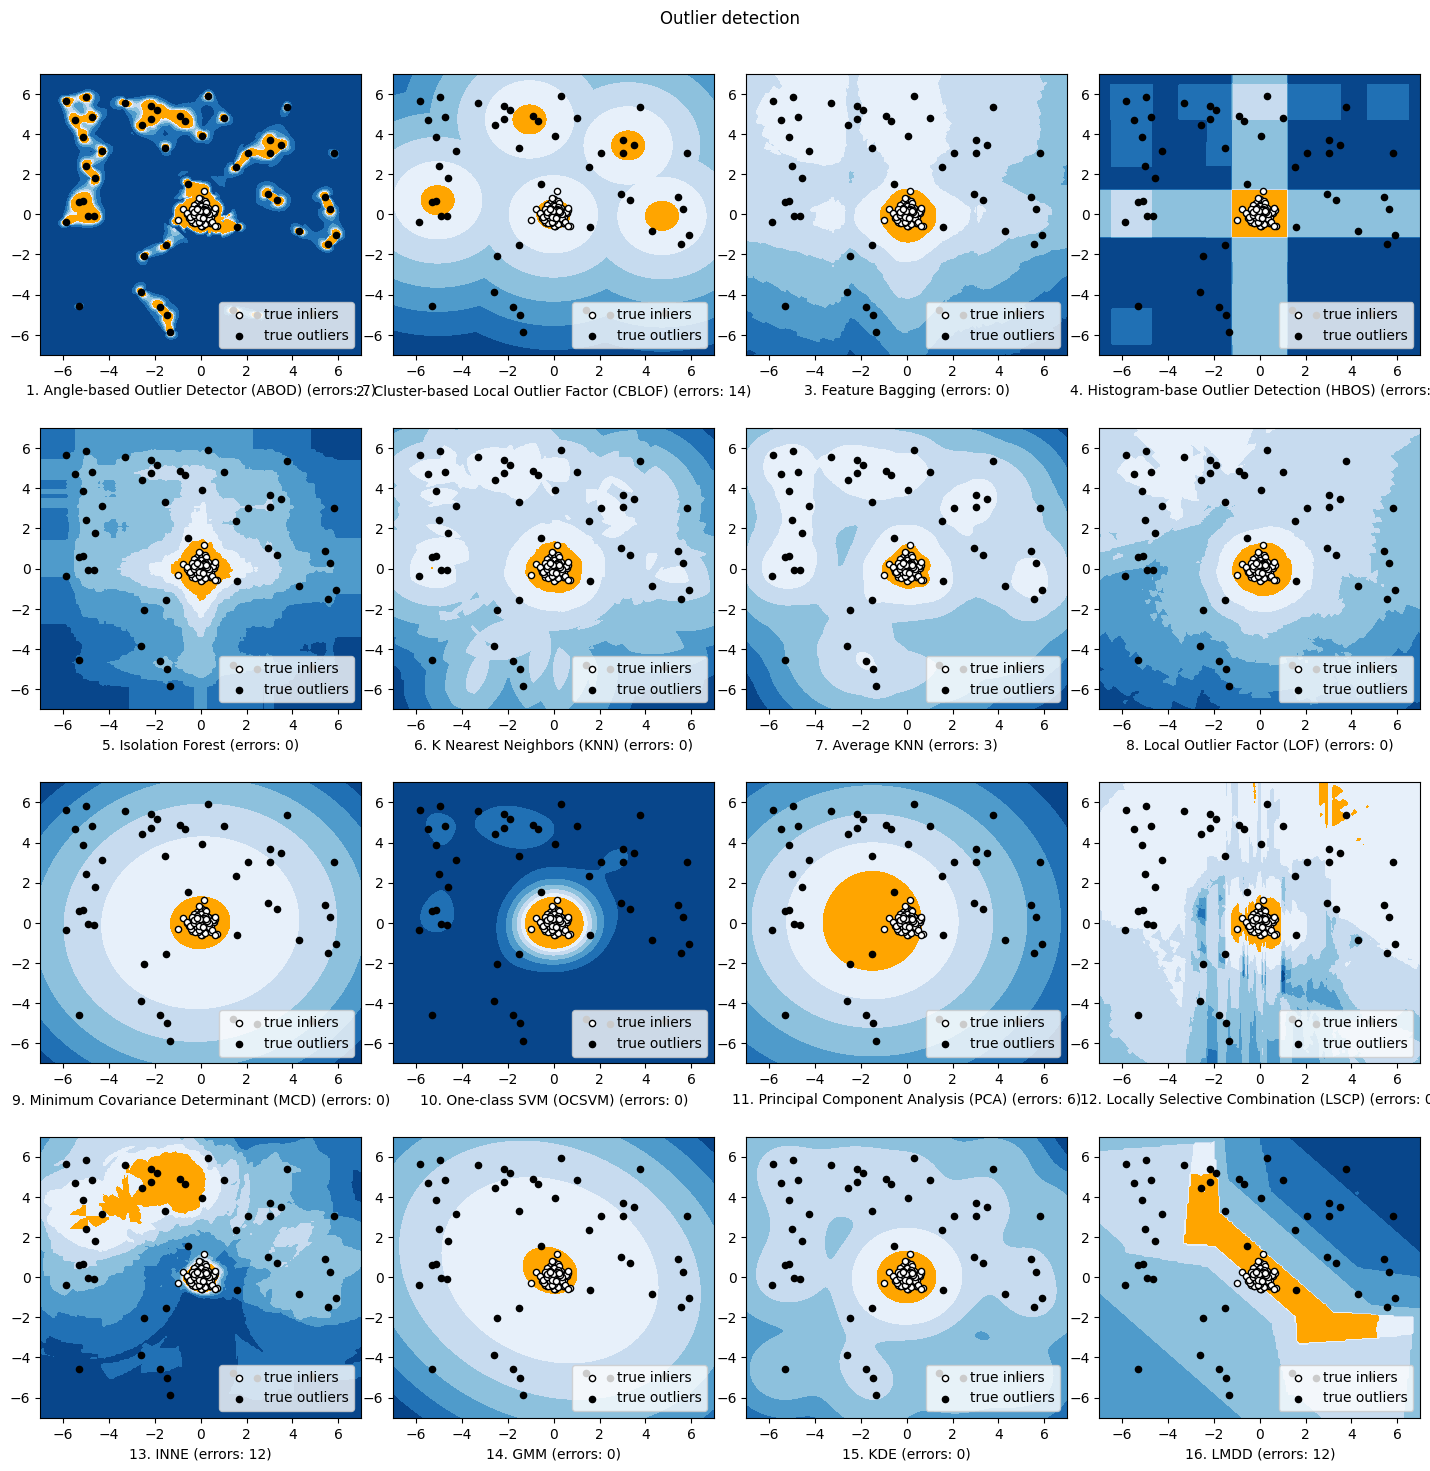

In [34]:
# Fit the models with the generated data and
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 16))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(4, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        # a = subplot.contour(xx, yy, Z, levels=[threshold],
        #                     linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [
                # a.collections[0],
                b, c],
            [
                # 'learned decision function',
                'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()

## 각모델의 장단점 존재
## 밀도가 높은것도있고 낮은것도있으며 이를 통해서 각각 다양한 설정들을 통해서 자기 자신에 맞는 classifier를 찾으면 됌